# Data Cleaning

This notebook contains the data cleaning phase of the project. The raw datasets have been downloaded from the Driven Data website. The datasets are as follows:

"test_set_values.csv": the competition testing set, containing only the id and the target variable ("status_group")

"training_set_labels.csv": the competition training set, containing the target variable

"training_set_values.csv": the competition training set, containing all the features

## Step 1
### Initial Setup

In [1]:
# importing relevant libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [2]:
# loading datasets into DataFrames
df_inspect = pd.read_csv('test_set_values.csv')
df2_inspect = pd.read_csv('training_set_labels.csv')
df3_inspect = pd.read_csv('training_set_values.csv')

The testing data set will be ignored for now, as it relates to the competition. The competition training data will be combined into a single DF for cleaning purposes, and will itself be split into testing/training/validation sets further down the line.

In [3]:
# Combining competition training sets
df4_combo = df3_inspect.join(df2_inspect, rsuffix='_r')
df5_combo = df4_combo.drop(['id_r'], axis=1)

## Step 2
### Data Exploration

The features included in the dataset are described as follows (as per the Driven Date website):

- **amount_tsh** - Total static head (amount water available to waterpoint)
- **date_recorded** - The date the row was entered
- **funder** - Who funded the well
- **gps_height** - Altitude of the well
- **installer** - Organization that installed the well
- **longitude** - GPS coordinate
- **latitude** - GPS coordinate
- **wpt_name** - Name of the waterpoint if there is one
- **num_private** -
- **basin** - Geographic water basin
- **subvillage** - Geographic location
- **region** - Geographic location
- **region_code** - Geographic location (coded)
- **district_code** - Geographic location (coded)
- **lga** - Geographic location
- **ward** - Geographic location
- **population** - Population around the well
- **public_meeting** - True/False
- **recorded_by** - Group entering this row of data
- **scheme_management** - Who operates the waterpoint
- **scheme_name** - Who operates the waterpoint
- **permit** - If the waterpoint is permitted
- **construction_year** - Year the waterpoint was constructed
- **extraction_type** - The kind of extraction the waterpoint uses
- **extraction_type_group** - The kind of extraction the waterpoint uses
- **extraction_type_class** - The kind of extraction the waterpoint uses
- **management** - How the waterpoint is managed
- **management_group** - How the waterpoint is managed
- **payment** - What the water costs
- **payment_type** - What the water costs
- **water_quality** - The quality of the water
- **quality_group** - The quality of the water
- **quantity** - The quantity of water
- **quantity_group** - The quantity of water
- **source** - The source of the water
- **source_type** - The source of the water
- **source_class** - The source of the water
- **waterpoint_type** - The kind of waterpoint
- **waterpoint_type_group** - The kind of waterpoint

The features were inspected one by one to determine if any need to be edited or removed. Below are the features for which an issue has been identified:

- **date_recorded**: deemed irrelevant for analysis - *to remove*
- **funder**: missing values, and too many single instances - *to fill and to cut down*
- **installer**: missing values, and too many single instances - *to fill and to cut down*
- **wpt_name**: deemed irrelevant for analysis - *to remove*
- **num_private**: empty feature - *to remove*
- **subvillage**: deemed irrelevant for analysis - *to remove*
- **region**: deemed irrelevant for analysis - *to remove*
- **region_code**: deemed irrelevant for analysis - *to remove*
- **district_code**: deemed irrelevant for analysis - *to remove*
- **lga**: deemed irrelevant for analysis - *to remove*
- **ward**: deemed irrelevant for analysis - *to remove*
- **public_meeting**: deemed irrelevant for analysis - *to remove*
- **recorded_by**: all values are the same, none missing - *to remove*
- **scheme_management**: missing values, duplicate of 'management' - *to remove*
- **scheme_name**: missing values, deemed irrelevant for analysis - *to remove*
- **permit**: missing values - *to fill*
- **construction_year**: mostly zero; not useful for analyis - *to convert to age in months and fill missing with median*
- **extraction_type_group** - subsumed by 'extraction_type' - *to remove*
- **extraction_type_class** - subsumed by 'extraction_type' - *to remove*
- **payment_type**: duplicate of 'payment' - *to remove*
- **water_quality**: subsumed by 'quality_group' - *to remove*
- **quantity_group**: duplicate of 'quantity' - *to remove*
- **source_type**: subsumed by 'source' - *to remove*
- **source_class**: subsumed by 'source' - *to remove*
- **waterpoint_type_group**: subsumed by 'waterpoint_type' - *to remove*

A specific point to mention is that the 'funder' and 'installer' variables have many singular instances, ie there are many organisations that have funded/installed a single well. This means that there is no useful insight to be gained from these features as they are, since a testing data point will probably not fit into any existing category here. To solve this, these two features will be limited to the top 6 installers and funders, and all remaining values will be grouped into a single value named 'small_org'.

## Step 3
### Processing

A function is created in order to clean the entire dataset. The function is documented below, and can also be used to clean the competition test set, if required.

In [4]:
# creating function to clean and rearrange dataframe

def preprocess_clean(dataframe, cols_to_drop, cols_to_fill, col_order, target_name):
    
    """Function to clean and rearrange dataframe for use in the model.
    
    The function will take the dataframe as an argument and perform the following operations:
    - Fill 'construction year' nil values with median non-zero value
    - Convert 'construction year' to age in years
    - Remove the rows identified as irrelevant
    - Fill categorical variable NAs with 'unknown'
    - Limit funders and installers to top five, with remaining values grouped into single value
    - Rearranges column order for readibility
    
    Args:
        'dataframe': the dataframe to clean
        'cols_to_drop': list of columns to drop from the dataframe
        'cols_to_fill': list of categorical columns to fill
        'col_order': list of columns in the desired order for the output
        'target_name': name (as string) of target variable
    
    Returns:
        A cleaned dataframe with the desired columns in the order specified
    """
    
    # creating copy of dataframe
    df = dataframe.copy()
    
    # converting 'construction_year' to age in years and filling zeros with median
    if 'construction_year' in df.columns:
        df.replace(0, np.nan, inplace=True)
        median_x = df['construction_year'].median(skipna=True)
        df['construction_year'].fillna(median_x, inplace=True)
        df['age_years'] = round(2019 - df['construction_year'],0)

    else:
        pass

    # dropping columns identified above as irrelvant
    df2 = df.drop(cols_to_drop, axis=1)
    
    # filling missing values with 'unknown' categorical
    df2[cols_to_fill] = df2[cols_to_fill].fillna(value='unknown')
    
    # limiting installers to top 6 only, with remaining values grouped together
    if 'installer' in df2.columns:
        installer_series = df2['installer'].value_counts()
        installer_series_2 = installer_series.sort_values(ascending=False)
        installer_top_6 = installer_series_2.index[0:6]
        installer_top_6_list = list(installer_top_6)
        df2['installer'] = df2['installer'].apply(lambda x: x if x in installer_top_6_list else 'small_inst')
    
    else:
        pass

    # limiting funders to top 6 only, with remaining values grouped together
    if 'funder' in df2.columns:
        funder_series = df2['funder'].value_counts()
        funder_series_2 = funder_series.sort_values(ascending=False)
        funder_top_6 = funder_series_2.index[0:6]
        funder_top_6_list = list(funder_top_6)
        df2['funder'] = df2['funder'].apply(lambda x: x if x in funder_top_6_list else 'small_fund')
    
    else:
        pass    
    
    # rearranging column order, and excluding target variable if not in dataframe
    if target_name in df2.columns:
        df3 = df2[col_order]
    else:
        list2 = order_cols[:order_cols.index(target_name)]+order_cols[order_cols.index(target_name)+1:]
        df3 = df2[list2]
    
    df4 = df3.fillna(0)
    
    return df4
    

In [5]:
# creating list of columns to drop, in order to pass into the cleaning function
drop_cols = ['date_recorded',
                'wpt_name',
                'num_private',
                'subvillage',
                'region',
                'region_code',
                'district_code',
                'lga',
                'ward',
                'public_meeting',
                'recorded_by',
                'scheme_management',
                'scheme_name',
                'construction_year',
                'extraction_type_group',
                'extraction_type_class',
                'payment_type',
                'water_quality',
                'quantity_group',
                'source_type',
                'source_class',
                'waterpoint_type_group']

# creating list of columns to fill with 'unknown'
fill_cols = ['funder',
            'installer',
            'permit']

# creating list of columns order
order_cols = ['id',
            'amount_tsh',
            'funder',
            'installer',
            'gps_height',
            'longitude',
            'latitude',
            'basin',
            'population',
            'permit',
            'extraction_type',
            'management',
            'management_group',
            'payment',
            'quality_group',
            'quantity',
            'source',
            'waterpoint_type',
            'age_years',
            'status_group',]

In [6]:
# cleaning the datatset using the cleaning function
df_clean = preprocess_clean(df5_combo, drop_cols, fill_cols, order_cols, 'status_group')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 20 columns):
id                  59400 non-null float64
amount_tsh          59400 non-null float64
funder              59400 non-null object
installer           59400 non-null object
gps_height          59400 non-null float64
longitude           59400 non-null float64
latitude            59400 non-null float64
basin               59400 non-null object
population          59400 non-null float64
permit              59400 non-null object
extraction_type     59400 non-null object
management          59400 non-null object
management_group    59400 non-null object
payment             59400 non-null object
quality_group       59400 non-null object
quantity            59400 non-null object
source              59400 non-null object
waterpoint_type     59400 non-null object
age_years           59400 non-null float64
status_group        59400 non-null object
dtypes: float64(7), object(13)
memory usage:

In [7]:
df_clean_2 = preprocess_clean(df_inspect, drop_cols, fill_cols, order_cols, 'status_group')
df_clean_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 19 columns):
id                  14850 non-null int64
amount_tsh          14850 non-null float64
funder              14850 non-null object
installer           14850 non-null object
gps_height          14850 non-null float64
longitude           14850 non-null float64
latitude            14850 non-null float64
basin               14850 non-null object
population          14850 non-null float64
permit              14850 non-null object
extraction_type     14850 non-null object
management          14850 non-null object
management_group    14850 non-null object
payment             14850 non-null object
quality_group       14850 non-null object
quantity            14850 non-null object
source              14850 non-null object
waterpoint_type     14850 non-null object
age_years           14850 non-null float64
dtypes: float64(6), int64(1), object(12)
memory usage: 2.2+ MB


In [8]:
df_clean.to_csv('df_clean.csv')

In [9]:
data = pd.read_csv('df_clean.csv')
data.head()

,Unnamed: 0,id,amount_tsh,funder,installer,gps_height,longitude,latitude,basin,population,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,waterpoint_type,age_years,status_group
0,0,69572.0,6000.0,small_fund,small_inst,1390.0,34.938093,-9.856322,Lake Nyasa,109.0,unknown,gravity,vwc,user-group,pay annually,good,enough,spring,communal standpipe,20.0,functional
1,1,8776.0,0.0,small_fund,small_inst,1399.0,34.698766,-2.147466,Lake Victoria,280.0,True,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,9.0,functional
2,2,34310.0,25.0,small_fund,small_inst,686.0,37.460664,-3.821329,Pangani,250.0,True,gravity,vwc,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,10.0,functional
3,3,67743.0,0.0,small_fund,small_inst,263.0,38.486161,-11.155298,Ruvuma / Southern Coast,58.0,True,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,33.0,non functional
4,4,19728.0,0.0,small_fund,small_inst,0.0,31.130847,-1.825359,Lake Victoria,0.0,True,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,19.0,functional


In [308]:
small_data = data.sample(frac=0.1, replace=True, random_state=1)

# Exploratory Data Analysis

In [10]:
data.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [98]:
#Just over half of the waterwells are functional 
#need to transform my categorical data into dummies. 
# first lets separate x and y
y = data['status_group']
X = data.drop(columns='status_group', axis=1)

In [310]:
#y = data['status_group'].replace(['non functional','fuctional needs repair'], ['needs repair','needs repair'], inplace=True)
#y = data.status_group = data.status_group.replace('functional needs repair', 'needs repair')
#y = y.replace('non functional', 'needs repair')
y = small_data.status_group = small_data.status_group.replace('functional needs repair', 'needs repair')
y = y.replace('non functional', 'needs repair')

In [100]:
data.status_group.value_counts()

functional        32259
non functional    22824
needs repair       4317
Name: status_group, dtype: int64

In [101]:
data.head()

,Unnamed: 0,id,amount_tsh,funder,installer,gps_height,longitude,latitude,basin,population,permit,extraction_type,management,management_group,payment,quality_group,quantity,source,waterpoint_type,age_years,status_group
0,0,69572.0,6000.0,small_fund,small_inst,1390.0,34.938093,-9.856322,Lake Nyasa,109.0,unknown,gravity,vwc,user-group,pay annually,good,enough,spring,communal standpipe,20.0,functional
1,1,8776.0,0.0,small_fund,small_inst,1399.0,34.698766,-2.147466,Lake Victoria,280.0,True,gravity,wug,user-group,never pay,good,insufficient,rainwater harvesting,communal standpipe,9.0,functional
2,2,34310.0,25.0,small_fund,small_inst,686.0,37.460664,-3.821329,Pangani,250.0,True,gravity,vwc,user-group,pay per bucket,good,enough,dam,communal standpipe multiple,10.0,functional
3,3,67743.0,0.0,small_fund,small_inst,263.0,38.486161,-11.155298,Ruvuma / Southern Coast,58.0,True,submersible,vwc,user-group,never pay,good,dry,machine dbh,communal standpipe multiple,33.0,non functional
4,4,19728.0,0.0,small_fund,small_inst,0.0,31.130847,-1.825359,Lake Victoria,0.0,True,gravity,other,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,19.0,functional


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

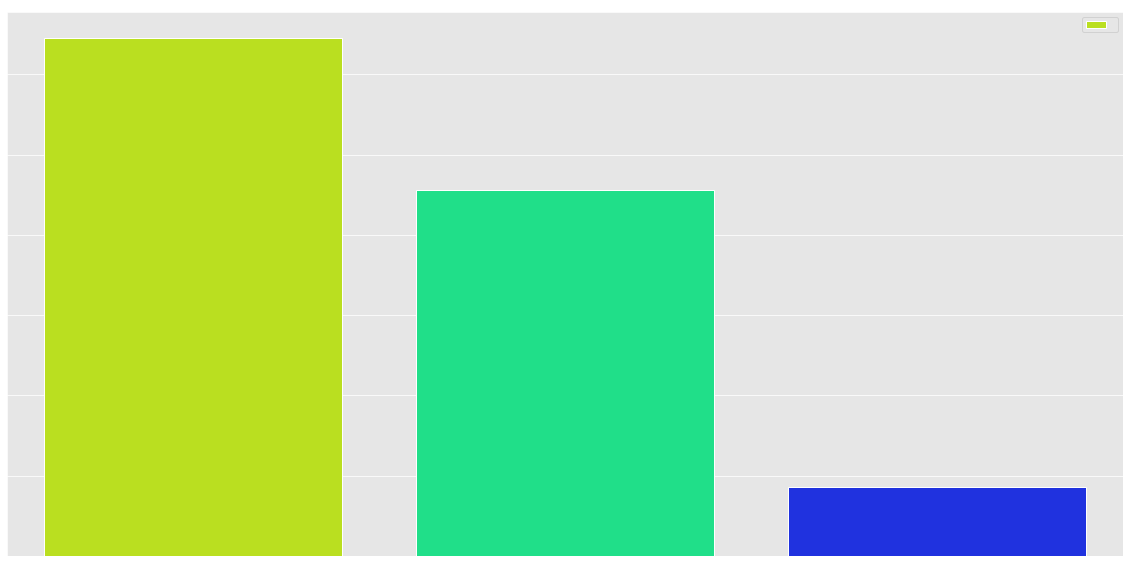

In [212]:
fig = plt.figure(figsize=(20,10))
sns.countplot(data['status_group'], palette='gist_rainbow')
plt.title("Waterwells Across Tanzania")
plt.xlabel("Wells")
plt.ylabel("Number of wells")
plt.legend(data['status_group'])
plt.show()

In [309]:
small_data = data.sample(frac=0.1, replace=True, random_state=1)

In [102]:
#change them into dummies so that it can be read into our models
X_d = pd.get_dummies(X)

In [215]:
#perform a train_test_split
from sklearn.model_selection import train_test_split
y = pd.get_dummies(y)
X = data.drop(columns=['status_group','id'], axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X_d, y, random_state=10) #x y train test split for train
#X_train_v, X_val, y_train_v, y_val = train_test_split(X_train,y_train,test_size=.2, random_state=123)
#y_val = y_val['functional']
#y_train = y_train['functional']
#y_train_v = y_train_v['functional']



In [104]:
print(y_train)

37648    1
17049    1
42569    1
58401    0
49211    1
        ..
28017    1
50496    0
29199    1
40061    1
17673    1
Name: functional, Length: 44550, dtype: uint8


# Baseline Model

In [107]:
from sklearn.linear_model import LogisticRegression
#instantiate the model 
baseline = LogisticRegression(solver='lbfgs',max_iter=1000)
baseline.fit(X_train_v,y_train_v)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
#From our logistic regression model, we are going to measure the ROC_AUC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

# Calculate the probability scores of each point in the training set
y_train_probs = baseline.predict_proba(X_train_v)[:,1] #probability prediction


# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train_v, y_train_probs)

# Calculate the probability scores of each point in the test set
y_val_probs = baseline.predict_proba(X_val)[:,1]

# Calculate the fpr, tpr, and thresholds for the test set
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_val_probs)

In [111]:
roc_auc_score(y_train_v, y_train_probs) #area for the score of the train data

0.6550257098598942

In [112]:
roc_auc_score(y_val, y_val_probs) #area for the score of the validation data


0.6609630196432281

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
fpr,tpr,thr = roc_curve(y_train,y_train_probs)
plt.plot(fpr,tpr)
print(auc(fpr,tpr))

ValueError: Found input variables with inconsistent numbers of samples: [44550, 35640]

Training AUC: 0.6472876460181256


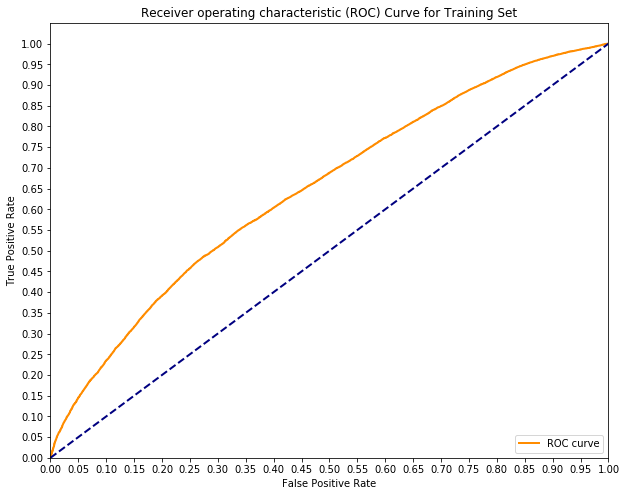

In [43]:

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [73]:
#using this from our hyperparameter lecture to make things a lot faster for visualisation on best models
from sklearn.metrics import roc_auc_score
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'validation:',round(val,2))

In [74]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

In [75]:
from sklearn.metrics import roc_curve
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [76]:
def opt_plots(opt_model):
    opt = pd.DataFrame(opt_model.cv_results_)
    cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
    params = pd.DataFrame(list(opt.params))
    opt = pd.concat([params,opt[cols]],axis=1,sort=False)
    
    plt.figure(figsize=[15,4])
    plt.subplot(121)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
    plt.title('ROC_AUC - Training')
    plt.subplot(122)
    sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
    plt.title('ROC_AUC - Validation')
#     return opt

# Logistic Regression, Learner 1

In [118]:
learner1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter = 1000, random_state=0)
learner1.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

train: 0.83 validation: 0.82


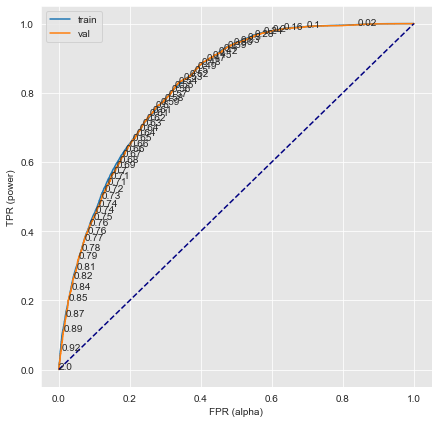

In [119]:
#train and validation curve without gridsearch on learner1
scores(learner1,X_train,X_val,y_train,y_val)
roc_plot(learner1,X_train,y_train,X_val,y_val)

Next step is to make a parameter that will likely be passed into gridsearchCV, this is an important step. I tried putting defaults rather than multiple values into my param grid and it resulted in gridsearch failing to pick the optimum. Instead it went for the defaults I plugged in.

In [120]:
import seaborn as sns 
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [121]:
#in order to perform a gridsearch i need to first identify our grid of parameters then perform a grid search 
#penalty = ['l1', 'l2']
C = [.001,.01,.1,1,100,1000]
#class_weight = [{1:.5, 0:.5},{1:.4, 0:.6}, {1:.6,0:.4}, {1:.7, 0:.3}]
solver = ['saga'] #liblinear is good for small datasets whereas saga is good for large
#add gridsearchCV
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
param_grid_l1 = dict(C=C, solver=solver)
opt_model= GridSearchCV(estimator=learner1, param_grid=param_grid_l1,cv=skf, scoring='roc_auc', verbose=1)

opt_model.fit(X_train, y_train)
best_model = opt_model.best_estimator_
#scores(best_model,X_train,X_val,y_train,y_val)
print(opt_model.best_params_)
print(opt_model.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-package

{'C': 100, 'solver': 'saga'}
0.577316474487599


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [122]:
print('Best Score:', opt_model.best_score_)
print('Best Parameters:',opt_model.best_params_ )

Best Score: 0.577316474487599
Best Parameters: {'C': 100, 'solver': 'saga'}


In [123]:
grid_result_val = opt_model.fit(X_val, y_val)
print('Best Score:', opt_model.best_score_)
print('Best Parameters:', opt_model.best_params_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached w

Best Score: 0.5716646880907624
Best Parameters: {'C': 1, 'solver': 'saga'}


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [124]:
print(opt_model.best_params_)


{'C': 1, 'solver': 'saga'}


In [183]:
# Calculate the prediction 
y_train_probs = learner1.predict_proba(X_train_v)[:,1] #probability prediction

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train_v, y_train_probs)

# Calculate the probability scores of each point in the test set
y_val_probs = learner1.predict_proba(X_val)[:,1]

# Calculate the fpr, tpr, and thresholds for the test set
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_val_probs)

In [195]:
#training accuracy and roc model
#print("Accuracy score:", accuracy_score(y_train_v, y_train_probs))
print("ROC model:", roc_curve(y_train_v, y_train_probs))

ROC model: (array([0.        , 0.        , 0.        , ..., 0.98990702, 0.98990702,
       1.        ]), array([0.00000000e+00, 5.18349575e-05, 1.96972838e-03, ...,
       9.99948165e-01, 1.00000000e+00, 1.00000000e+00]), array([1.99977421e+00, 9.99774213e-01, 9.76481063e-01, ...,
       5.70336829e-04, 5.70211632e-04, 1.49115302e-04]))


Training AUC: 0.8264127778103869


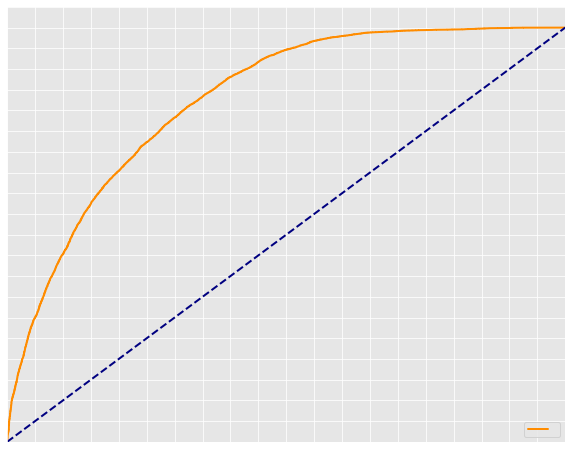

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [193]:
#validation roc_model and accuracy score
y_val_probs = learner1.predict_proba(X_val)[:,1]
#print("Accuracy score:", accuracy_score(y_val, y_val_probs))
print("ROC model:", roc_curve(y_val, y_val_probs))
print("TPR:", tpr)
print("FPR:", fpr)

ROC model: (array([0.        , 0.        , 0.        , ..., 0.99951172, 0.99951172,
       1.        ]), array([0.00000000e+00, 2.07727462e-04, 8.30909846e-04, ...,
       9.99792273e-01, 1.00000000e+00, 1.00000000e+00]), array([1.99999995e+00, 9.99999951e-01, 9.98204869e-01, ...,
       2.34509113e-04, 2.10932938e-04, 1.68041080e-04]))
TPR: [0.00000000e+00 8.29668962e-05 2.07417241e-04 ... 9.99958517e-01
 1.00000000e+00 1.00000000e+00]
FPR: [0.        0.        0.        ... 0.9996576 0.9996576 1.       ]


In [ ]:
#calculate fm score, need to consider the cost of our mistakes in our threshold selection
fm = 

Validation AUC: 0.8238560890923609


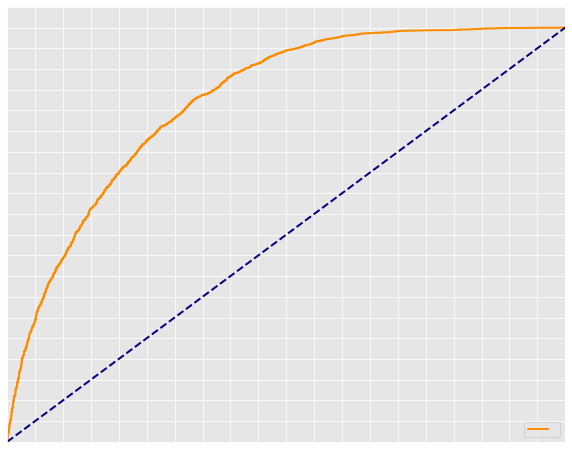

In [187]:
#printing the validation set insights
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(val_fpr, val_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Validation Set')
plt.legend(loc='lower right')
print('Validation AUC: {}'.format(auc(val_fpr, val_tpr)))
plt.show()

In [ ]:
#

# DecisionTrees, Learner 2

In [ ]:
from sklearn.tree import DecisionTreeClassifier
learner2 = DecisionTreeClassifier(max_iter =1000, random_state=42)
learner2.fit(X_train,y_train)

In [ ]:
#add gridsearch

Here I am taking in my second learner model. It is a decision tree classifier.

In [ ]:
y_train_probs_dt = learner2.predict_proba(X_train)[:,1] #probability prediction

# Calculate the fpr, tpr, and thresholds for the training set
train_fpr, train_tpr, thresholds = roc_curve(y_train_v, y_train_probs_dt)

# Calculate the probability scores of each point in the test set
y_val_probs_dt = learner2.predict_proba(X_val)[:,1]

# Calculate the fpr, tpr, and thresholds for the test set
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, y_val_probs_dt)
print(auc(fpr, tpr))

In [ ]:
#Validation set
print("Accuracy score:", accuracy_score(y_val, y_val_probs_dt))
print("ROC model:", roc_curve(y_val, y_val_probs_dt))

In [ ]:
# ROC curve for training set
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(train_fpr, train_tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Training Set')
plt.legend(loc='lower right')
print('Training AUC: {}'.format(auc(train_fpr, train_tpr)))
plt.show()

In [134]:
#did not have time to do a gridsearch here

# Learner 3: XGBoost

In [348]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.externals.joblib import parallel_backend
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [349]:
#small_data = data.sample(frac=0.1, replace=True, random_state=1)
X_trainv_small, x_val_small, y_trainv_small, y_val_small = train_test_split(X_train_v, y_train_v, test_size=.2, random_state=1)

#y_val = y_val['functional']
#y_train = y_train['functional']
#y_train_v = y_train_v['functional']


In [350]:
# scaler = StandardScaler()
# x_trainv_scaled = scaler.fit_transform(X_train_v)[:,1]


In [351]:
X_trainv_small.shape

(28512, 103)

In [352]:
y_trainv_small.shape

(28512,)

In [353]:
#there is about 50k+ i need to make my gridsearchCV quick and easy to run so 
#i will take a sample from my x_train_v
# x_sample_train_v,y_sample_train_v, x_sample, y_sample = train_test_split(X_train_v, y_train_v, test_size=.7, random_state=1)
# y_sample_train_v = y_sample['functional']
# y_sample = y_sample['functional']



In [354]:
learner3 = xgb.XGBClassifier(max_iter=1000,random_state=0)
learner3.fit(X_trainv_small, y_trainv_small)
training_probs = learner3.predict_proba(X_trainv_small)[:,1]
roc_training_auc = roc_auc_score(y_trainv_small, training_preds)

print("Training ROC Auc: {:.4}%".format(roc_training_auc * 100))


Training ROC Auc: 84.79%


In [355]:
type(xgb)

module

In [369]:
#time for hyper parameter optimisation on XGBoost
#lets start with a paramgrid
param_grid_l3 = {
    "learning_rate": [100],
    'max_depth': [5,10],
    'min_child_weight': [5,10],
    'n_estimators': [30, 100],
}

In [372]:
# grid_scv = GridSearchCV(learner3, param_grid_l3, scoring='accuracy')
grid_scv = GridSearchCV(estimator=learner3, param_grid=param_grid_l3,cv=skf, scoring='roc_auc', verbose=1)
grid_scv.fit(x_val_small, y_val_small)

best_model = grid_scv.best_estimator_
print(grid_scv.best_params_)
print(grid_scv.best_score_)

#best_parameters = grid_scv.best_params_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   23.6s finished


{'learning_rate': 100, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 30}
0.5


In [365]:
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_scv.predict(X_train)
training_accuracy = accuracy_score(y_train, training_preds)
val_preds = grid_scv.predict(X_test)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 


NameError: name 'best_parameters' is not defined